# DTSA 5510 Final Project - Big Mart Sales Data

## Project Topic

In this project I will be using the Big Mart Sales Data to solve the problem of customer segmentation utilizing unsupervised learning. The goal of this project is to be able to identify groups of customers that exhibit similar or distinct purchasing behaviors. This type of analysis could help Big Mart to create customized and targeted campaigns for specific groups and improve what products they offer to certain groups. To answer to problem of customer segmentation, I will be using unsupervised learning techniques like K-Means clustering and PCA. These will be valuable tools for BigMart to better understand their customers.

## Data Description

The BigMart sales dataset consists of 2013 sales data for 1559 products across 10 different outlets in different cities. The BigMart sales dataset also consists of certain attributes for each product and store.I found this public dataset here: https://www.kaggle.com/datasets/brijbhushannanda1979/bigmart-sales-data

As we can see below the Train dataset has 8523 rows and 12 columns. We have numeric columns like Item_Weight, Item_Visibility, Item_MRP, and Item_Outlet_Sales. While we also have some categorical columns like Item_Fat_Content, Item_Type, Outlet_Size, Outlet_Identifier, etc. 

In [87]:
import pandas as pd

train_data = pd.read_csv('Train.csv')

In [82]:
print(f"Number of rows: {train_data.shape[0]}")
print(f"Number of columns: {train_data.shape[1]}")

Number of rows: 8523
Number of columns: 12


In [83]:
print(train_data.head(10))

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15        9.300          Low Fat         0.016047   
1           DRC01        5.920          Regular         0.019278   
2           FDN15       17.500          Low Fat         0.016760   
3           FDX07       19.200          Regular         0.000000   
4           NCD19        8.930          Low Fat         0.000000   
5           FDP36       10.395          Regular         0.000000   
6           FDO10       13.650          Regular         0.012741   
7           FDP10          NaN          Low Fat         0.127470   
8           FDH17       16.200          Regular         0.016687   
9           FDU28       19.200          Regular         0.094450   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  1

These are the datatypes for the columns which will be helpful to take note of.

In [10]:
# Check for data types
print(train_data.dtypes)

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object


## Data Cleaning and EDA

Looking below - seems like Item_Weight and Outlet_Size have missing values.

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
# Check for missing values
print(train_data.isnull().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


Lets handle those missing values through imputation. Now we got rid of the missing values.

In [85]:
# Impute missing values in Item_Weight column with mean value
train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean(), inplace=True)
test_data['Item_Weight'].fillna(test_data['Item_Weight'].mean(), inplace=True)

# Impute missing values in Outlet_Size column with mode value
train_data['Outlet_Size'].fillna(train_data['Outlet_Size'].mode()[0], inplace=True)
test_data['Outlet_Size'].fillna(test_data['Outlet_Size'].mode()[0], inplace=True)

# Check for missing values again
print(train_data.isnull().sum())
print(test_data.isnull().sum())

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64
Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64


Will be checking for duplicates now.

In [86]:
# Check for duplicates
print(train_data.duplicated().sum())


0


Now lets visualize for outliers.

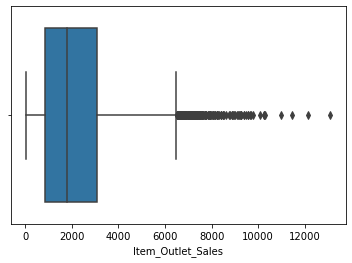

In [9]:
# Check for outliers
sns.boxplot(x='Item_Outlet_Sales', data=train_data)
plt.show()

Now looking at the distribution of the Item_Outlet_Sales

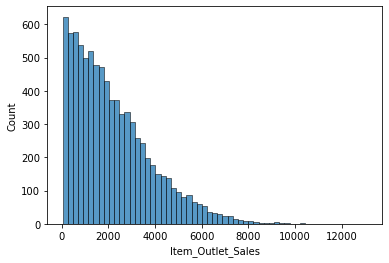

In [11]:
sns.histplot(x='Item_Outlet_Sales', data=train_data)
plt.show()

Looking at trends with a scatterplot of Item_MRP and Item_Outlet_Sales

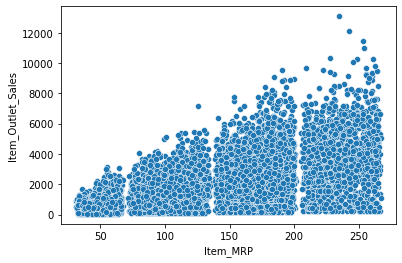

In [12]:
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=train_data)
plt.show()

Now creating a heatmap will be helpful to look at any possible correlations.

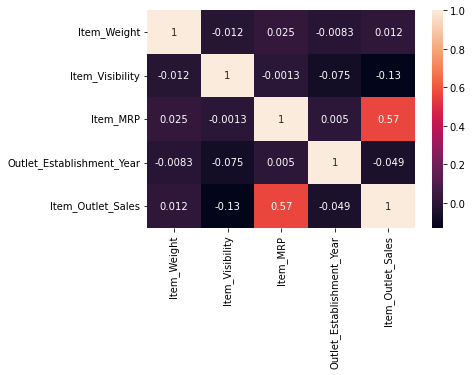

In [13]:
sns.heatmap(train_data.corr(), annot=True)
plt.show()

Now lets do some exploration on the categorical variables we have using some visualizations.

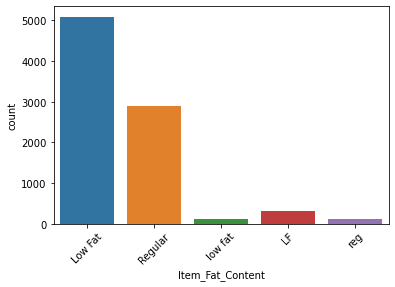

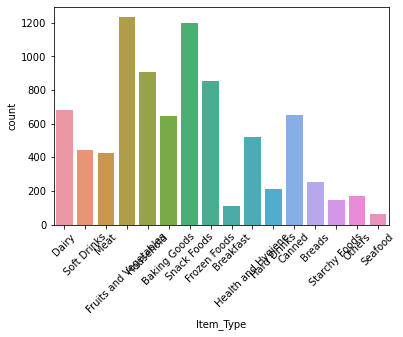

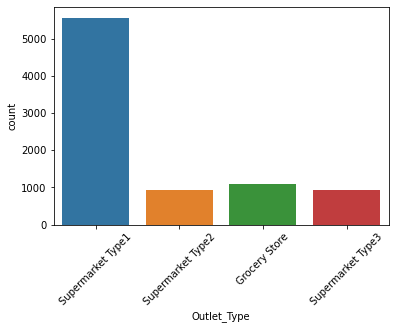

In [19]:
# Explore the categorical variables
cat_vars = ["Item_Fat_Content", "Item_Type", "Outlet_Type"]
for var in cat_vars:
    sns.countplot(x=var, data=train_data)
    plt.xticks(rotation=45)
    plt.show()

### Explore patterns in the data and associations

The output below shows the antecedents (items that precede the consequents) and consequents (items that follow the antecedents) of each association rule: along with support, confidence, lift, leverage, and conviction measures.

The support measure indicates the proportion of transactions in which both the antecedent and consequent items appear. The confidence measure indicates the proportion of transactions containing the antecedent that are also contain the consequent. The lift measure indicates the degree of association between the antecedent and consequent items, with values greater than 1 indicating a positive association. The leverage measure indicates the difference between the observed frequency of co-occurrence of the antecedent and consequent items and the frequency expected under independence assumption. 


In [30]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules



# Generate item sets
train_data["Item_Identifier"] = train_data["Item_Identifier"].apply(lambda x: x[0:2])
basket = (train_data.groupby(["Outlet_Identifier", "Item_Identifier"])["Item_Outlet_Sales"]
          .sum().unstack().reset_index().fillna(0)
          .set_index("Outlet_Identifier"))
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)
frequent_itemsets = apriori(basket_sets, min_support=0.03, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values("lift", ascending=False, inplace=True)

# Analyze the results
print(rules.head())

  antecedents consequents  antecedent support  consequent support  support  \
0        (DR)        (FD)                 1.0                 1.0      1.0   
1        (FD)        (DR)                 1.0                 1.0      1.0   
2        (DR)        (NC)                 1.0                 1.0      1.0   
3        (NC)        (DR)                 1.0                 1.0      1.0   
4        (NC)        (FD)                 1.0                 1.0      1.0   

   confidence  lift  leverage  conviction  
0         1.0   1.0       0.0         inf  
1         1.0   1.0       0.0         inf  
2         1.0   1.0       0.0         inf  
3         1.0   1.0       0.0         inf  
4         1.0   1.0       0.0         inf  


C:\Users\gjaqu\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


# Analysis

## Clustering

### Feature Selection

To select the relevant features that capture the key aspects of customer behavior I will need to analyze the data and identify the variables that are most relevant to the problem I am trying to solve. In this case, I want to identify groups of customers that exhibit similar/distinct purchasing behaviors. Therefore, lets select variables that are related to customer purchases.

Some of the variables that I can consider for this analysis are:

Item_Type: Type of product purchased by the customer
Item_MRP: Maximum Retail Price of the product
Outlet_Type: Type of outlet where the product was purchased
Outlet_Location_Type: Location of the outlet
Outlet_Size: Size of the outlet
Item_Outlet_Sales: Sales of the product in the outlet

In [39]:
selected_features = ['Item_Type', 'Item_MRP', 'Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Item_Outlet_Sales']
data = train_data[selected_features]


In [41]:
from sklearn.preprocessing import OneHotEncoder
# One-hot encode the categorical features
encoder = OneHotEncoder()
cat_data = encoder.fit_transform(data[selected_features])

# Combine the encoded categorical features and numerical features
num_data = data.drop(selected_features, axis=1)
data = np.concatenate((num_data, cat_data.toarray()), axis=1)

### Standardization

Next, I'll need to standardize the selected features so that they have the same mean and variance. Creating this standardization step is important because K-Means clustering is sensitive to the scale of the data. I can use the StandardScaler function from the scikit-learn library to standardize the data.

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


Just a quick double check to make sure we still have the same dimensions


In [52]:
print(scaled_data.shape)
print(data.shape)


(8523, 9457)
(8523, 9457)


### PCA

Here with the PCA process I'll be create the PCA class with the desired # of components. Then I will need to fit the model to the scaled data created before this step. After that I'll need to transform the data to the new PCA space. 

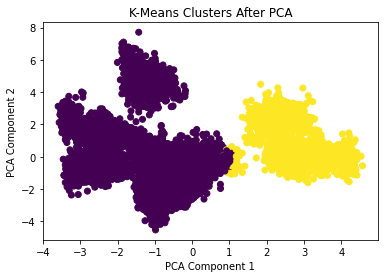

In [88]:
from sklearn.decomposition import PCA

# PCA class with the desired number of components
pca = PCA(n_components=2)

# Fit the PCA model to the scaled data
pca.fit(scaled_data)

# Transform the data to the new PCA space
pca_data = pca.transform(scaled_data)

# Visualize the transformed data
plt.scatter(pca_data[:,0], pca_data[:,1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters After PCA')
plt.show()


### Determine the Number of Clusters

To determine the optimal number of clusters for the data I'll be using the elbow method. The elbow method involves plotting the within-cluster sum of squares (WCSS) as a function of the number of clusters. After doing that then will be selecting the number of clusters at the "elbow" of the plot. 

Let's use the elbow method to determine the optimal number of clusters:

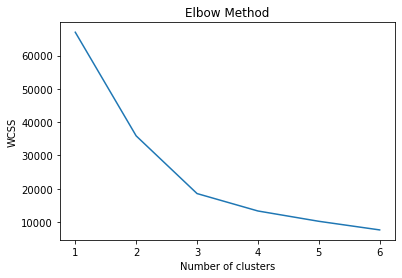

In [75]:
wcss = []
for i in range(1, 7):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 7), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Perform K-Means Clustering

Now that we have determined the optimal number of clusters, we can apply the K-Means algorithm to the standardized data with 2 clusters

In [76]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(pca_data)

### Results : Analyze Clusters
Will visualize the resulting clusters from the transformed data.

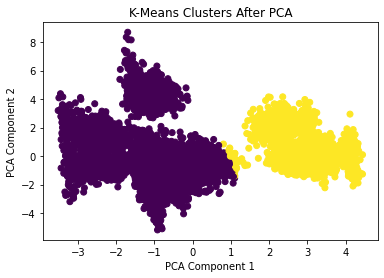

In [78]:
# Visualize the transformed data and the resulting clusters
plt.scatter(pca_data[:,0], pca_data[:,1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters After PCA')
plt.show()

Now will analyze those clusters using the centroid 

In [79]:
# Analyze clusters by examining the centroid and the characteristics of the customers in each cluster
cluster_analysis = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
cluster_analysis['Cluster'] = clusters
cluster_analysis.groupby('Cluster').mean()

,PC1,PC2
Cluster,,
0,-1.204525,-0.168660
1,2.973808,0.416398


In [80]:
# create a new DataFrame with the PCA data and cluster labels
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

# analyze clusters
cluster_analysis = pca_df.groupby('cluster').mean()
print(cluster_analysis)

              PC1       PC2
cluster                    
0       -1.204525 -0.168660
1        2.973808  0.416398


# Conclusion/Discussion

The PCA analysis and K-means clustering have identified two distinct clusters of customers based on their purchasing behaviors. Cluster 0, which is characterized by negative values for PC1 and PC2, represents customers who make lower value purchases less often. While Cluster 1 is characterized by positive values for PC1 and PC2 and represents customers who make higher value purchases more often.

This information is useful for targeted marketing campaigns or tailored product recommendations. For example, businesses could use this information to offer promotions or discounts to customers in Cluster 0 to encourage them to make more frequent purchases or to focus on providing high-value products or services to customers in Cluster 1.

In conclusion, the Big Mart Sales data problem focused on the task of customer segmentation, which involves identifying groups of customers with similar/distinct purchasing behaviors. First started by selecting relevant features and then standardized them using the StandardScaler function. Next used PCA to reduce the dimensionality of the data and transform it to a new space. Then performed K-Means clustering to identify distinct clusters of customers. Determined the optimal number of clusters using the elbow method. Lastly, analyzed the resulting clusters using visualization and cluster analysis.


Customer segmentation utilizing techniques like K-Means clustering and PCA can be a valuable tool for businesses like BigMart to better understand their customers and tailor their marketing campaigns and product offerings to specific customer segments.